In [1]:
# global definitions (Fig 10)

import os

import pandas as pd

from scipy.stats import pearsonr

import numpy as np

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from common_defs import *

import pickle

data_dir = 'plos_asonam_exp_data/'

countries = {'France': 'france_own', 'Italy': 'italy_own', 'Germany': 'germany', 'Spain': 'spain', 'UK': 'uk_own'}

latent_dims = ['latent_dimension_0', 'latent_dimension_1', 'latent_dimension_2', 'latent_dimension_3', 'latent_dimension_4']
lat_dim_alias = ['d%d'%(d + 1) for d in range(len(latent_dims))]

country_ref_groups = {'France': 'FranceOwn_reference_group.csv', 'Italy': 'ItalyOwn_reference_group.csv', 
                      'Germany': 'Germany_reference_group.csv', 'Spain': 'Spain_reference_group.csv', 
                      'UK': 'UKOwn_reference_group.csv'}

country_group_data = {'France': 'FranceOwn_group_attitudes.csv', 'Italy': 'ItalyOwn_group_attitudes.csv', 
                      'Germany': 'Germany_group_attitudes.csv', 'Spain': 'Spain_group_attitudes.csv', 
                      'UK': 'UKOwn_group_attitudes.csv'}

country_colors = {'France': 'blue', 'Italy': 'green', 'Germany': '#FF7F24', 'Spain': 'brown', 'UK': '#98F5FF'}

# which attitudinal dimensions to choose
attitudinal_prefix = 'ches'

ches_dic = {}
ches_dic['ches_econ_interven'] = 'Opposes economic interventionism'
ches_dic['ches_eu_intmark'] = 'Favors EU internal market'
ches_dic['ches_redistribution'] = 'Opposes redistribution'
ches_dic['ches_eu_budgets'] = 'Favors EU budget authority'
ches_dic['ches_deregulation'] = 'Favors market de-regulation'
ches_dic['ches_lrecon'] = 'Left - economy - Right'
ches_dic['ches_spendvtax'] = 'Favors tax cuts'
ches_dic['ches_lrecon_dissent'] = 'Economic ideology party dissent'
ches_dic['ches_eu_position'] = 'Favors EU integration'
ches_dic['ches_russian_interference'] = 'Importance of Russian interference'
ches_dic['ches_religious_principles'] = 'Favors religious principles'
ches_dic['ches_lrgen'] = 'Left - ideology - Right'
ches_dic['ches_eu_cohesion'] = 'Favors EU cohesion'
ches_dic['ches_eu_foreign'] = 'Favors EU foreign/security pol.'
ches_dic['ches_lrecon_blur'] = 'Econ. ideology party blurriness'
ches_dic['ches_environment'] = 'Favors economy over ecology'
ches_dic['ches_civlib_laworder'] = 'Crime-fighting over liberties'
ches_dic['ches_galtan_salience'] = 'GAL/TAN (salience)'
ches_dic['ches_urban_rural'] = 'Favors rural over urban'
ches_dic['ches_sociallifestyle'] = 'Opposes liberal lifestyle'
ches_dic['ches_ethnic_minorities'] = 'Opposes special rights minorities'
ches_dic['ches_eu_asylum'] = 'Favors EU asylum authority'
ches_dic['ches_eu_salience'] = 'EU integration (salience)'
ches_dic['ches_multiculturalism'] = 'Opposes multiculturalism'
ches_dic['ches_immigrate_policy'] = 'Favors immigration restrictions'
ches_dic['ches_multicult_dissent'] = 'Anti-multiculturalism party dissent'
ches_dic['ches_multicult_salience'] = 'Anti-multiculturalism (salience)'
ches_dic['ches_nationalism'] = 'Favors nationalism'
ches_dic['ches_anti_islam_rhetoric'] = 'Anti-islam rhetoric (salience)'
ches_dic['ches_galtan'] = 'GAL/TAN'
ches_dic['ches_immigrate_salience'] = 'Immigration restrictions (salience)'
ches_dic['ches_immigrate_dissent'] = 'Immigration restrictions party dissent'
ches_dic['ches_members_vs_leadership'] = 'Favors party leaders over members'
ches_dic['ches_lrecon_sd'] = 'Economic ideology (std. dev.)'
ches_dic['ches_galtan_blur'] = 'GAL/TAN party blurriness'
ches_dic['ches_galtan_dissent'] = 'GAL/TAN party dissent'
ches_dic['ches_enviro_salience'] = 'Economy over ecology (salience)'
ches_dic['ches_regions'] = 'Opposes decentralization'
ches_dic['ches_eu_dissent'] = 'EU integration party dissent'
ches_dic['ches_lrecon_salience'] = 'Economic ideology (salience)'
ches_dic['ches_eu_blur'] = 'EU integration party blurriness'
ches_dic['ches_corrupt_salience'] = 'Importance of fighting corruption'
ches_dic['ches_galtan_sd'] = 'GAL/TAN (std. dev.)'
ches_dic['ches_people_vs_elite'] = 'Favors people over elites'
ches_dic['ches_eu_position_sd'] = 'EU integration (std. dev.)'
ches_dic['ches_antielite_salience'] = 'People over elites (salience)'
ches_dic['ches_redist_salience'] = 'Anti-redistribution (salience)'
ches_dic['ches_protectionism'] = 'Favors trade protectionism'

# file to save the correlations objects
correlations_object_file = 'dimension_correlations.pkl'

In [2]:
# load latent and attitudinal dimensions

ref_coords = {}
ref_groups = {}
group_data = {}

for country in countries:
    ref_filename = os.path.join(data_dir, countries[country], 'exp_results/target_ideological_dimensions.csv')
    ref_coords[country] = pd.read_csv(ref_filename)
    ref_coords[country]['target_id'] = ref_coords[country]['target_id'].astype(int)
    ref_coords[country] = ref_coords[country][['target_id'] + latent_dims]
    ref_coords[country].rename(columns = dict(zip(latent_dims, lat_dim_alias)), inplace = True)
    
    ref_group_filename = os.path.join(data_dir, countries[country], country_ref_groups[country])
    ref_groups[country] = pd.read_csv(ref_group_filename)
    ref_coords[country]['k'] = ref_coords[country]['target_id'].map(pd.Series(index=ref_groups[country]['i'].values,data = ref_groups[country]['k'].values))
    
    group_data_filename = os.path.join(data_dir, countries[country], country_group_data[country])
    group_data[country] = pd.read_csv(group_data_filename)

In [3]:
# also compute dimensions of parties (as the mean point of references in the party)

group_dimensions = {}
for country in countries:
    group_dimensions[country] = ref_coords[country].groupby('k')[lat_dim_alias].mean()
    group_dimensions[country] = group_dimensions[country].reset_index()

In [4]:
for country in countries:
    group_data[country] = pd.merge(group_data[country], group_dimensions[country], on = 'k', how = 'inner')

In [5]:
# compute correlations

corr = {}   # r of Pearson correlation
#corrav = {} # absolute value of r
corp = {}   # p-value of Pearson correlation
#corm = {}   # slope of affine fitted model
#corb = {}   # intersect of affine fitter model

for country in countries:
    
    attitudinal_cols = [col for col in group_data[country].columns if col.startswith(attitudinal_prefix)]
    
    corr[country] = pd.DataFrame(index = lat_dim_alias, columns = attitudinal_cols)
    #corrav[country] = pd.DataFrame(index = lat_dim_alias, columns = attitudinal_cols)
    corp[country] = pd.DataFrame(index = lat_dim_alias, columns = attitudinal_cols)
    
    #corm[country] = pd.DataFrame(index = lat_dim_alias, columns = attitudinal_cols)
    #corb[country] = pd.DataFrame(index = lat_dim_alias, columns = attitudinal_cols)
    
    for ld in lat_dim_alias:
        for ac in attitudinal_cols:
            
            df = group_data[country][[ld, ac]].dropna()
            
            # correlations
            corr[country].loc[ld, ac], corp[country].loc[ld, ac] = pearsonr(df[ld], df[ac])
            #corrav[country].loc[ld, ac] = np.abs(corr[country].loc[ld, ac])
            
            # affine fit
            #corm[country].loc[ld, ac], corb[country].loc[ld, ac] = np.polyfit(df[ld], df[ac], 1)

In [6]:
# save correlations object

pickle.dump(corr, open(correlations_object_file, "wb") )

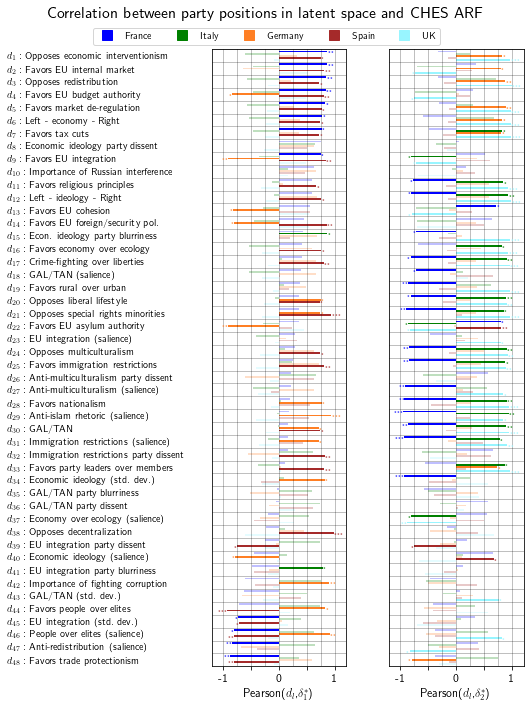

In [7]:
# visualize cross-country latent space correlation
latent_correlation_legend = []
for country in countries:
    latent_correlation_legend.append(Line2D([0], [0], color = country_colors[country],  marker = 's', 
                                            markersize = 10, lw = 0, linestyle = 'None', alpha = 1, label = country))
    
#Convention:
    #- att dims are arranged in "slots" packed vertically
    #- att dim "name" is at the center of the slot

# latent dimension to compute order with
lead_dim = 'd1'

ordered_attitudinal_cols = corr['France'].loc[lead_dim].sort_values(ascending = False).index.values

# independent parameters of the figure
N_slots = len(attitudinal_cols)
slots_height = N_slots * 4
fig_height = 10
subfig_width = 2.5
text_fs = 10
text_x_pos = -0.2
N_dims = 2
buffer_subfigs = 0
buffer_v_slot = 0.1
barheight_frac = 0.9 # fraction of the total possible space
starsep = 0.01 # separation between end of bar and significance stars
starfs = 5 # font size of the significance stars
insignificantalpha = 0.25 # alpha of bars with no significant p-value
legend_fs = 10

# dependent parameters of the figure
slot_bins = np.linspace(0, slots_height, N_slots + 1)
slot_base = slot_bins[:-1]
slot_top = slot_bins[1:]
slot_centers = 0.5 * (slot_bins[1:] + slot_bins[:-1])
slot_height = slot_bins[1] - slot_bins[0]
country_subslots_bins = np.linspace(slot_height * buffer_v_slot, slot_height * (1 - buffer_v_slot), len(countries) + 1)
country_subslots_centers = 0.5 * (country_subslots_bins[1:] + country_subslots_bins[:-1])
barheight = barheight_frac * (country_subslots_bins[1] - country_subslots_bins[0] )
bar_rel_slot_ypos = {}

for i, country in enumerate(list(countries.keys())[::-1]):
    bar_rel_slot_ypos[country] = country_subslots_centers[i]
    
# rendering the figure
fig = plt.figure(figsize = ((N_dims + buffer_subfigs + 1) * subfig_width, fig_height))
ax={}
# text subfig with name of attitudinal dimensions
ax['t'] = fig.add_subplot(1, (N_dims + buffer_subfigs + 1), 1)
for i, attdim in enumerate(ordered_attitudinal_cols):
    ax['t'].text(text_x_pos, slot_centers[-(1 + i)] - 0.3 * slot_height, r'$d_{%d}:$ '%(i+1) + ches_dic[attname(attdim)],
                 fontsize = text_fs)
    
# setting up axis
ax['t'].set_ylim((0,slots_height))
ax['t'].axis('off')
# ax['t'].tick_params(axis='both',which='both',left=False,right=False,top=False,bottom=False,labelleft=True) 
ax['t'].set_ylabel('CHES party attitudinal dimensions')
# subfig with latent dimension-wise correlations
for i,d in enumerate(lat_dim_alias[:N_dims]):
    ax[d] =fig.add_subplot(1,(N_dims+buffer_subfigs+1),1+buffer_subfigs+(i+1))
    # drawing the bars
    for j,attdim in enumerate(ordered_attitudinal_cols):
        slot_idx = -(1+j)
        for country in countries:
            r = corr[country].loc[d,attdim]                
            # bars
            alphaval = 1 if corp[country].loc[d,attdim]<0.05 else insignificantalpha
            ax[d].barh(y=slot_base[slot_idx]+bar_rel_slot_ypos[country],width=r,
                       height=barheight,color=country_colors[country],alpha=alphaval)
            # stars
            if corp[country].loc[d,attdim]<0.05:
                ha = 'left' if r>=0 else 'right'
                ax[d].text(r+starsep*np.sign(r),slot_base[slot_idx]+bar_rel_slot_ypos[country]-barheight*1.35,
                           sgnf(corp[country].loc[d,attdim]),color=country_colors[country],
                           fontsize=starfs,ha=ha)
        # hlines  
        ax[d].axhline(slot_top[slot_idx],color='k',alpha=0.5,linewidth=0.5)
    # v lines
    for xo in [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]:
        ax[d].axvline(xo,color='k',alpha=0.5,linewidth=0.5)
    # setting up axis
    ax[d].set_ylim((0,slots_height))
    ax[d].set_xlim((-1.2,1.2))
    ax[d].set_xticks([-1,-0.5,0,0.5,1])
    ax[d].set_xticklabels(['-1','','0','','1'])
    ax[d].tick_params(axis='y',which='both',left=False,right=False,labelleft=False) 
    ax[d].set_xlabel('Pearson('+r'$d_{l}$'+','+r'$\delta^*_{%d}$'%(i+1)+')')
# ax[d].legend(handles=latent_correlation_legend,fontsize=legend_fs,loc='lower right',ncols=4)
fig.suptitle("Correlation between party positions in latent space and CHES ARF\n", fontsize=16)
plt.tight_layout()
plt.figlegend(handles=latent_correlation_legend, loc = 'lower center', 
              ncol=len(countries), labelspacing=0,fontsize=legend_fs,bbox_to_anchor=(0.5,0.921) )

plt.show()

#plt.savefig('Figures/Correlations/countries_correlations_%s.pdf'%attitudinal_prefix)
#plt.close()